## Load data and get heartbeats

In [74]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import time
from sklearn.decomposition import FastICA, PCA
from sklearn.cluster import KMeans, DBSCAN
import os
from scipy.signal import find_peaks
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd # To check the Keys etc.
from sklearn.decomposition import FastICA, PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
import tensorflow as tf
#from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from scipy.signal import find_peaks
import os
import scipy.signal
import scipy.stats
from scipy.fft import fft, fftfreq
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
import math
from sklearn.mixture import GaussianMixture


In [83]:
def plot_heartbeats(heartbeats, faster_heartbeat):
    plt.figure(figsize=(12, 6))
    
    # Plot the first heartbeat
    plt.subplot(2, 1, 1)
    plt.plot(heartbeats[0])
    plt.title('Heartbeat 1')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    
    # Plot the second heartbeat
    plt.subplot(2, 1, 2)
    plt.plot(heartbeats[1])
    plt.title('Heartbeat 2')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    
    plt.tight_layout()
    plt.show()
    
    # Plot the faster heartbeat
    plt.figure(figsize=(6, 4))
    plt.plot(faster_heartbeat)
    plt.title('Faster Heartbeat')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.show()

def peak_density(data_array):
    peak_count, _ = find_peaks(data_array, height=level)  # Adjust the 'height' parameter to change sensitivity
    peak_count = len(peak_count)
    peak_density = peak_count / len(data_array)
    return peak_density\

def extract_heartbeats(filename, sampling_rate=360):
    # Open file
    mat_file = loadmat(filename)
    data = mat_file['val'].reshape(4, -1)    
    
    # ICA to extract signals from mixture
    decomposed_data = FastICA(n_components=4).fit_transform(data.T).T
    
    # Threshold to distinguish heartbeat and noise
    threshold = 1
    spike_counts = np.sum(decomposed_data > threshold, axis=1)
    
    # Heartbeats have fewer spikes than noise
    idx_heartbeats = np.argsort(spike_counts)[:2]
    
    heartbeats = decomposed_data[idx_heartbeats]

    # Ensure heartbeats are oriented correctly
    # for i in range(len(heartbeats)):
    #     if np.max(np.abs(heartbeats[i])) == np.abs(np.min(heartbeats[i])):
    #         heartbeats[i] = -heartbeats[i]
    
    # def calculate_rr_intervals(heartbeat):
    #     r_peaks = np.where(heartbeat > np.mean(heartbeat))[0]
    #     rr_intervals = np.diff(r_peaks) / sampling_rate
    #     return rr_intervals
    
    # # Calculate RR intervals for each heartbeat
    # rr_intervals_1 = calculate_rr_intervals(heartbeats[0])
    # rr_intervals_2 = calculate_rr_intervals(heartbeats[1])
    
    # # Calculate average RR interval for each heartbeat
    # avg_rr_1 = np.mean(rr_intervals_1) if len(rr_intervals_1) > 0 else float('inf')
    # avg_rr_2 = np.mean(rr_intervals_2) if len(rr_intervals_2) > 0 else float('inf')
    
    # # Determine the faster heartbeat (shorter average RR interval)
    # faster_heartbeat = heartbeats[0] if avg_rr_1 < avg_rr_2 else heartbeats[1]
    for i in range(153):
        dens1 = peak_density(heartbeats[0])
        dens2 = peak_density(heartbeats[1])
    if dens1 > dens2:
        faster_heartbeat=(heartbeats[0])
        #skipped_files=(heartbeats[1])
    else:
        faster_heartbeat=(heartbeats[1])
        #skipped_files=(heartbeats[0])

    #plot_heartbeats(heartbeats, faster_heartbeat)
    
    return faster_heartbeat

__path__ = 'data/test-data/011'

normalizer_standart = StandardScaler()
normalizer_minmax = MinMaxScaler()

def load_mat_file(file_path):
    mat = scipy.io.loadmat(file_path)

    return mat

def flatten(arr,variable):
    data = arr[variable]
    data= data.flatten()
    return data

def get_mean_std(signal):
    mean = float(np.mean(signal))
    std_dev = float(np.std(signal))
    return mean, std_dev

def calculate_zScore(x,mean, std_dev):

    z_score = float((x-mean)/std_dev)
    return z_score

def Check_Spikes(a, threshold,mean, std_dev): # Sets 0 if under the threshold 
    temp_zScore = calculate_zScore(a,mean, std_dev)
    if abs(temp_zScore) >= threshold:
        return a
    elif temp_zScore < threshold:
        return 0

def fix_signal_shape(data_array):
    temp_data = []

    temp_mean, temp_std = get_mean_std(data_array)
    
    for i in range(data_array.size):
        temp_data.append(Check_Spikes(data_array[i], 2.0, temp_mean, temp_std))

    # Calculate the mean of the processed data
    channel_mean = np.mean(temp_data, dtype=np.float64)
    

    if channel_mean < 0:
        data_array = -data_array
    
    return data_array

def print_key_values(path):
    sample_1 = load_mat_file(path)

    keys = []
    values = []

    for key, value in sample_1.items():
        if not key.startswith('__'):  # Skip internal meta-keys
            keys.append(key)
            values.append(value.shape if hasattr(value, 'shape') else 'Not an array')

    # Create a DataFrame for better formatting
    df = pd.DataFrame({'Key': keys, 'Shape': values})

    # Print the table
    print(df)

def Apply_ICA(data):
    # Perform ICA
    ica = FastICA(
    n_components=4,        # Number of components to extract        # Perform whitening
    fun='logcosh',         # Contrast function for independence
    max_iter=5000,          # Maximum number of iterations
    tol=1e-6,              # Tolerance for convergence
    random_state=2        # Ensure reproducibility
)
    ica_components = ica.fit_transform(data.T).T
    x = np.linspace(0, data.shape[1], data.shape[1])
    return ica_components, x

def Apply_FFT(ica_components):
    fft_results = np.fft.fft(ica_components, axis=1)
    n = ica_components.shape[1]
    frequencies = np.fft.fftfreq(n)
    return fft_results, frequencies
# Perform FFT on ICA results

def Analyse_FFT_Result(frequencies, fft_results,weight_decay_factor = 0.96):
    
    Sum_of_frequency = []
    for i in range(4):

        middle_index = len(frequencies) // 2
        low_freqs = np.abs(fft_results[i, :middle_index])
        high_freqs = np.abs(fft_results[i, middle_index:]) 
        weights = np.array([weight_decay_factor**i for i in range(len(low_freqs))])
        reversed_weights = np.array([weight_decay_factor**(i+len(low_freqs)) for i in range(len(high_freqs))])
        weighted_low_freqs = low_freqs * weights
        weighted_high_freqs = high_freqs * reversed_weights
        temp_sum = np.sum(weighted_low_freqs) + np.sum(weighted_high_freqs)
        Sum_of_frequency.append(temp_sum)
        # Add up the values and print
        print(f"Sum of frequency components for channel {i}: {Sum_of_frequency[i]}")


    temp_max = 0
    temp_max2 = 0
    for i in range(4):

        if (Sum_of_frequency[i] > temp_max):  
            #temp_max2 = temp_max
            temp_max = Sum_of_frequency[i]
            max_index = i

    for i in range(4):
        
        if (Sum_of_frequency[3-i] > temp_max2) & (3-i != max_index):
            temp_max2 = Sum_of_frequency[3-i]
            max_index2 = 3-i

    return max_index, max_index2


level =2
def peak_density(data_array):
    peak_count, _ = find_peaks(data_array, height=level)  # Adjust the 'height' parameter to change sensitivity
    peak_count = len(peak_count)
    peak_density = peak_count / len(data_array)
    return peak_density

def IterateoverFiles(Mat_File_count,Plot=0,batch_size = 5, path = 'data/test-data/',weight_decay_factor = 0.96):
    heartbeat_mixed = np.empty((2, Mat_File_count+1), dtype=object)
    for i in range(0, Mat_File_count+1, batch_size):
        if Plot == 1:
            fig, ax = plt.subplots(batch_size, 2, figsize=(15, 20))
    
        for batch_idx, j in enumerate(range(i, min(i + batch_size, 153))):
            #path = 'Unsupervised-Team-8/problem-2/data/test-data/'
            mat_file = load_mat_file(path + f"{j:03}.mat")
            data00 = mat_file['val'].reshape(4, -1)

            # Perform ICA

            ica_components, x = Apply_ICA(data00)        

            # Perform FFT on ICA results
            fft_results, frequencies = Apply_FFT(ica_components) 

            # Analyze FFT to find max components
            max_index, max_index2 = Analyse_FFT_Result(frequencies,fft_results, weight_decay_factor)

            # Store max components in heartbeat_mixed array
            heartbeat_mixed[0, j] = fix_signal_shape(ica_components[max_index, :])
            heartbeat_mixed[1, j] = fix_signal_shape(ica_components[max_index2, :])
        if Plot == 1:    
            # Plot ICA components with max_index and max_index2 for the current file
            ax[batch_idx, 0].plot(x, heartbeat_mixed[0, j], color='blue')
            ax[batch_idx, 0].set_title(f'ICA Max Component {batch_idx+1} for File {j:03}')
            ax[batch_idx, 0].set_xlabel('Time')
            ax[batch_idx, 0].set_ylabel(f'Amplitude({np.mean(heartbeat_mixed[0, j]):02})')

            ax[batch_idx, 1].plot(x, heartbeat_mixed[1, j], color='red')
            ax[batch_idx, 1].set_title(f'ICA 2nd Max Component {batch_idx+1} for File {j:03}')
            ax[batch_idx, 1].set_xlabel('Time')
            ax[batch_idx, 1].set_ylabel(f'Amplitude({np.mean(heartbeat_mixed[1, j]):02})')
        
            plt.tight_layout()
            plt.show()
            print(f"Batch starting at index {i}: Max index: {max_index}, 2nd Max index: {max_index2}")

    return heartbeat_mixed
heartbeat_mixed = IterateoverFiles(152,0)
#heartbeat_mixed = heartbeat_mixed.reshape(-1, 1)
unmixed_heartbeat = []
skipped_files = []

for i in range(153):
    dens1 = peak_density(heartbeat_mixed[0][i])
    dens2 = peak_density(heartbeat_mixed[1][i])
    if dens1 > dens2:
        unmixed_heartbeat.append(heartbeat_mixed[0][i])
        skipped_files.append(heartbeat_mixed[1][i])
    else:
        unmixed_heartbeat.append(heartbeat_mixed[1][i])
        skipped_files.append(heartbeat_mixed[0][i])

directory = 'data/test-data'

all_test_heartbeats =[]

for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)
    if os.path.isfile(file_path):
        if filename.endswith('.mat'):
            heartbeats = extract_heartbeats(file_path)
            all_test_heartbeats.append(heartbeats)
        
    
    

Sum of frequency components for channel 0: 2008.7518200375089
Sum of frequency components for channel 1: 106.31178872313376
Sum of frequency components for channel 2: 1510.230012836082
Sum of frequency components for channel 3: 907.2331887730231
Sum of frequency components for channel 0: 3037.7580682315174
Sum of frequency components for channel 1: 373.842297965681
Sum of frequency components for channel 2: 4153.042009502897
Sum of frequency components for channel 3: 1018.824892518747
Sum of frequency components for channel 0: 2352.070326440215
Sum of frequency components for channel 1: 110.23553356434215
Sum of frequency components for channel 2: 2302.9041195818522
Sum of frequency components for channel 3: 896.355016818659
Sum of frequency components for channel 0: 2240.0803787933155
Sum of frequency components for channel 1: 95.36490213452204
Sum of frequency components for channel 2: 1920.9802535438364
Sum of frequency components for channel 3: 694.5642216208574
Sum of frequency co

## Some plot functions

In [77]:
def plot_heartbeats(heartbeats, faster_heartbeat):
    plt.figure(figsize=(12, 6))
    
    # Plot the first heartbeat
    plt.subplot(2, 1, 1)
    plt.plot(heartbeats[0])
    plt.title('Heartbeat 1')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    
    # Plot the second heartbeat
    plt.subplot(2, 1, 2)
    plt.plot(heartbeats[1])
    plt.title('Heartbeat 2')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    
    plt.tight_layout()
    plt.show()
    
    # Plot the faster heartbeat
    plt.figure(figsize=(6, 4))
    plt.plot(faster_heartbeat)
    plt.title('Faster Heartbeat')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.show()

# Example usage


## Extract features and cluster

153


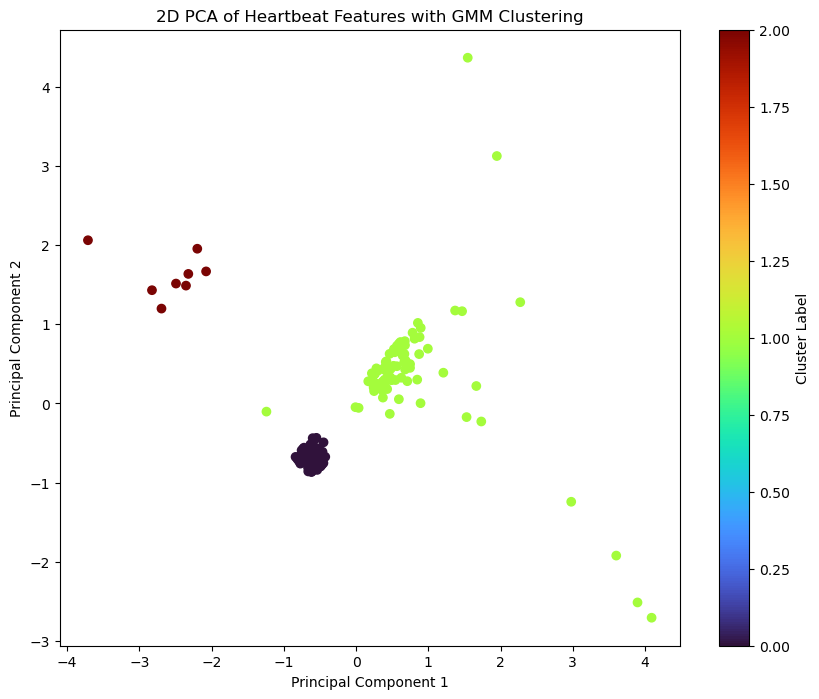

Principal Component 1: 60.16% variance explained
Principal Component 2: 39.84% variance explained
Total variance explained by selected components: 100.00%


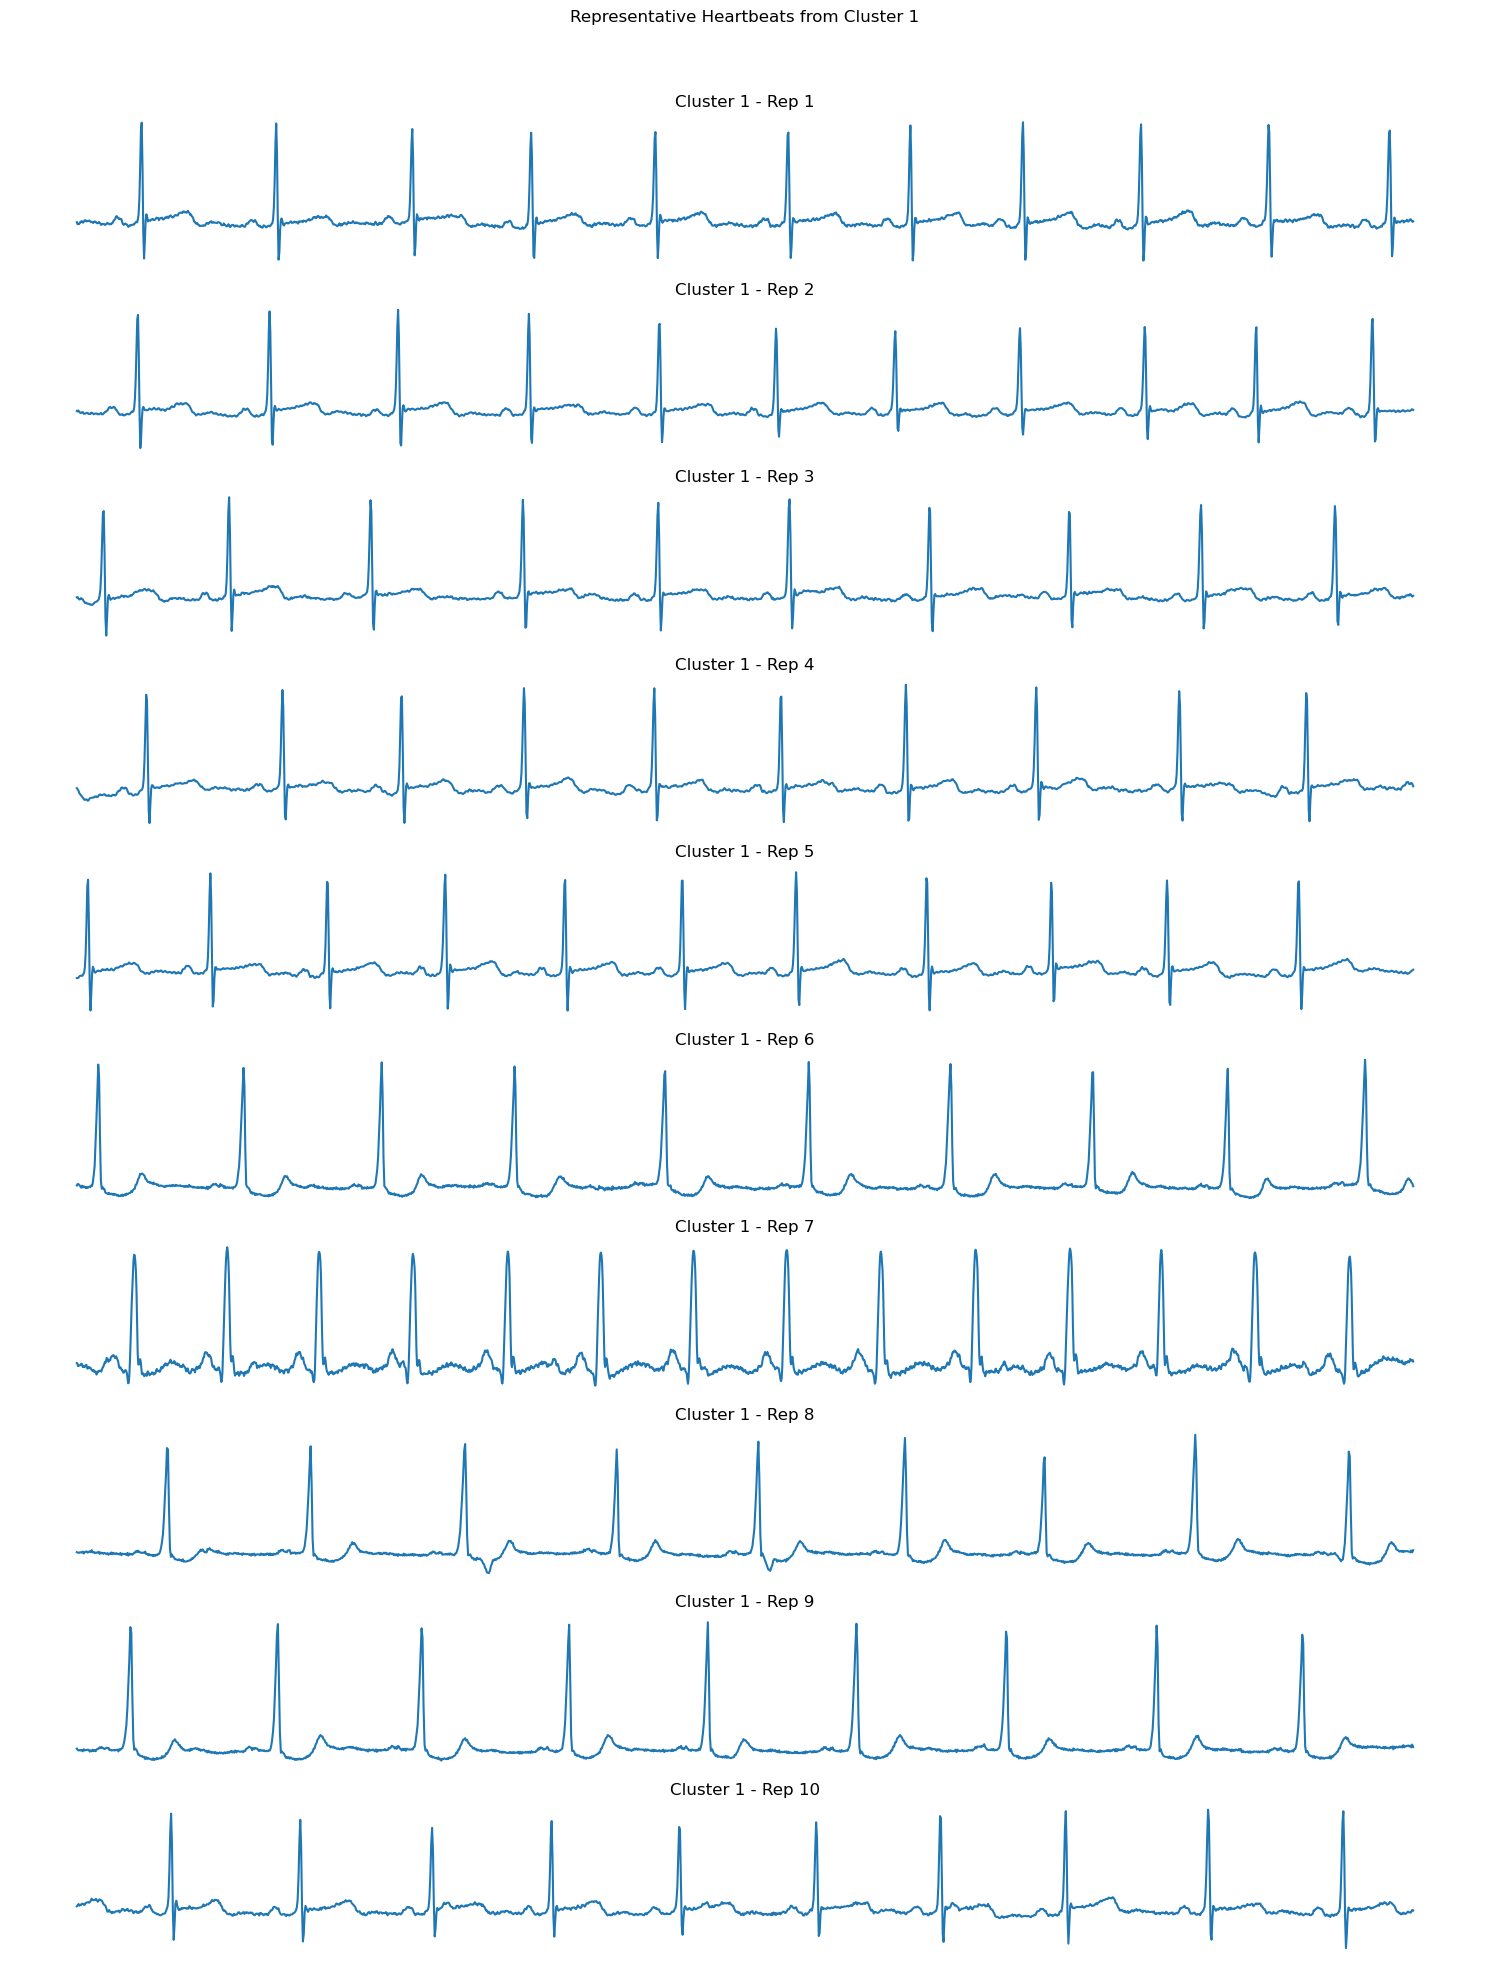

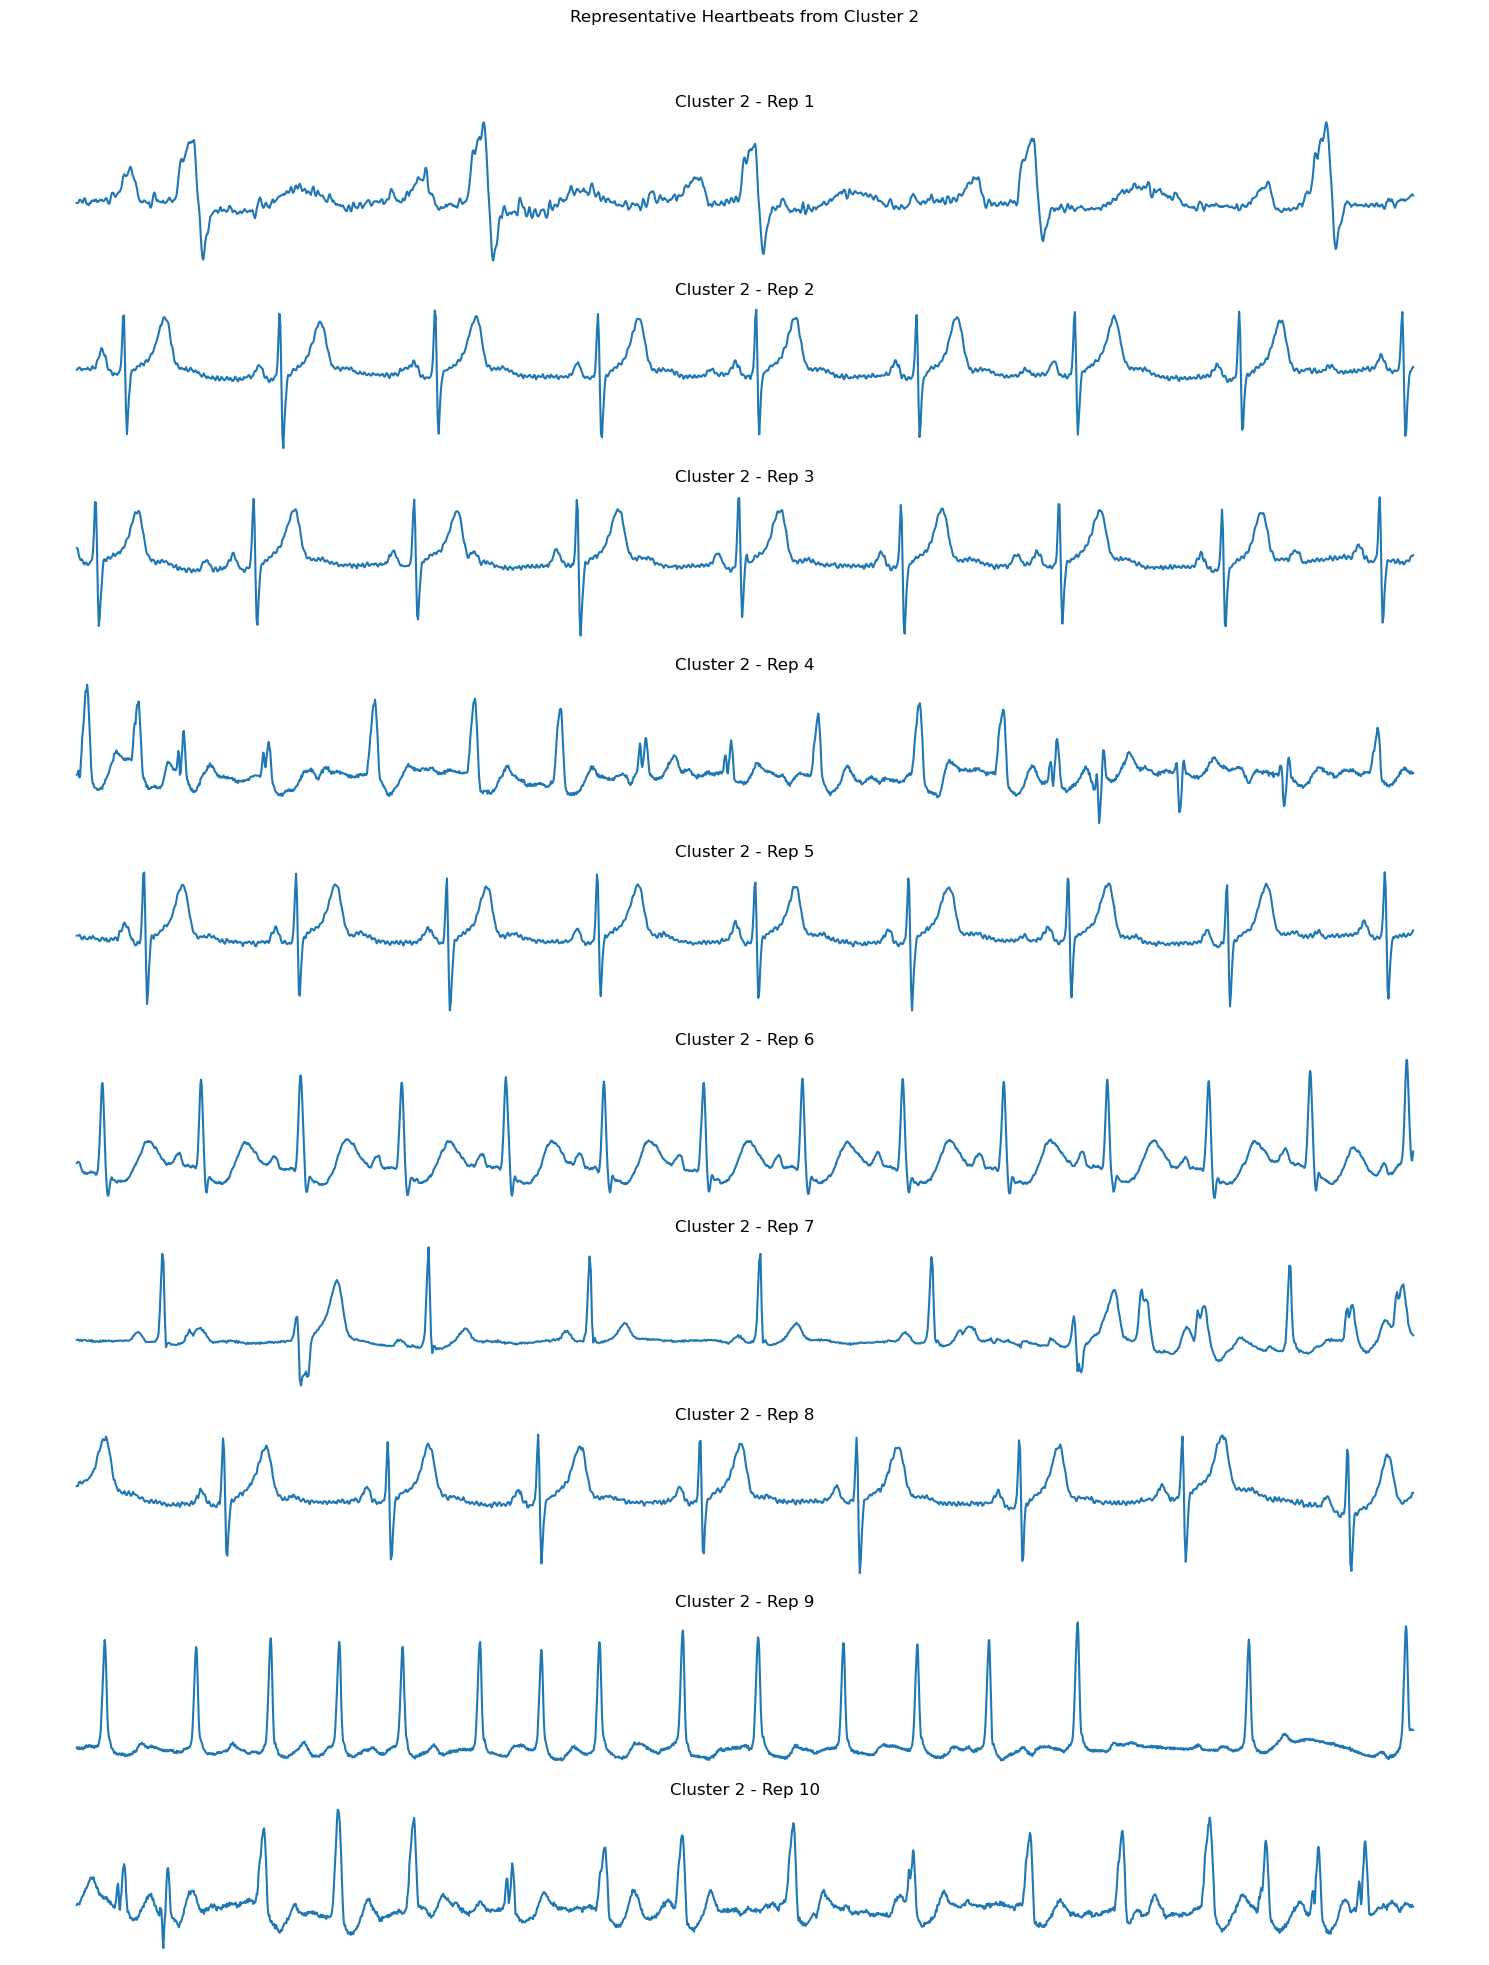

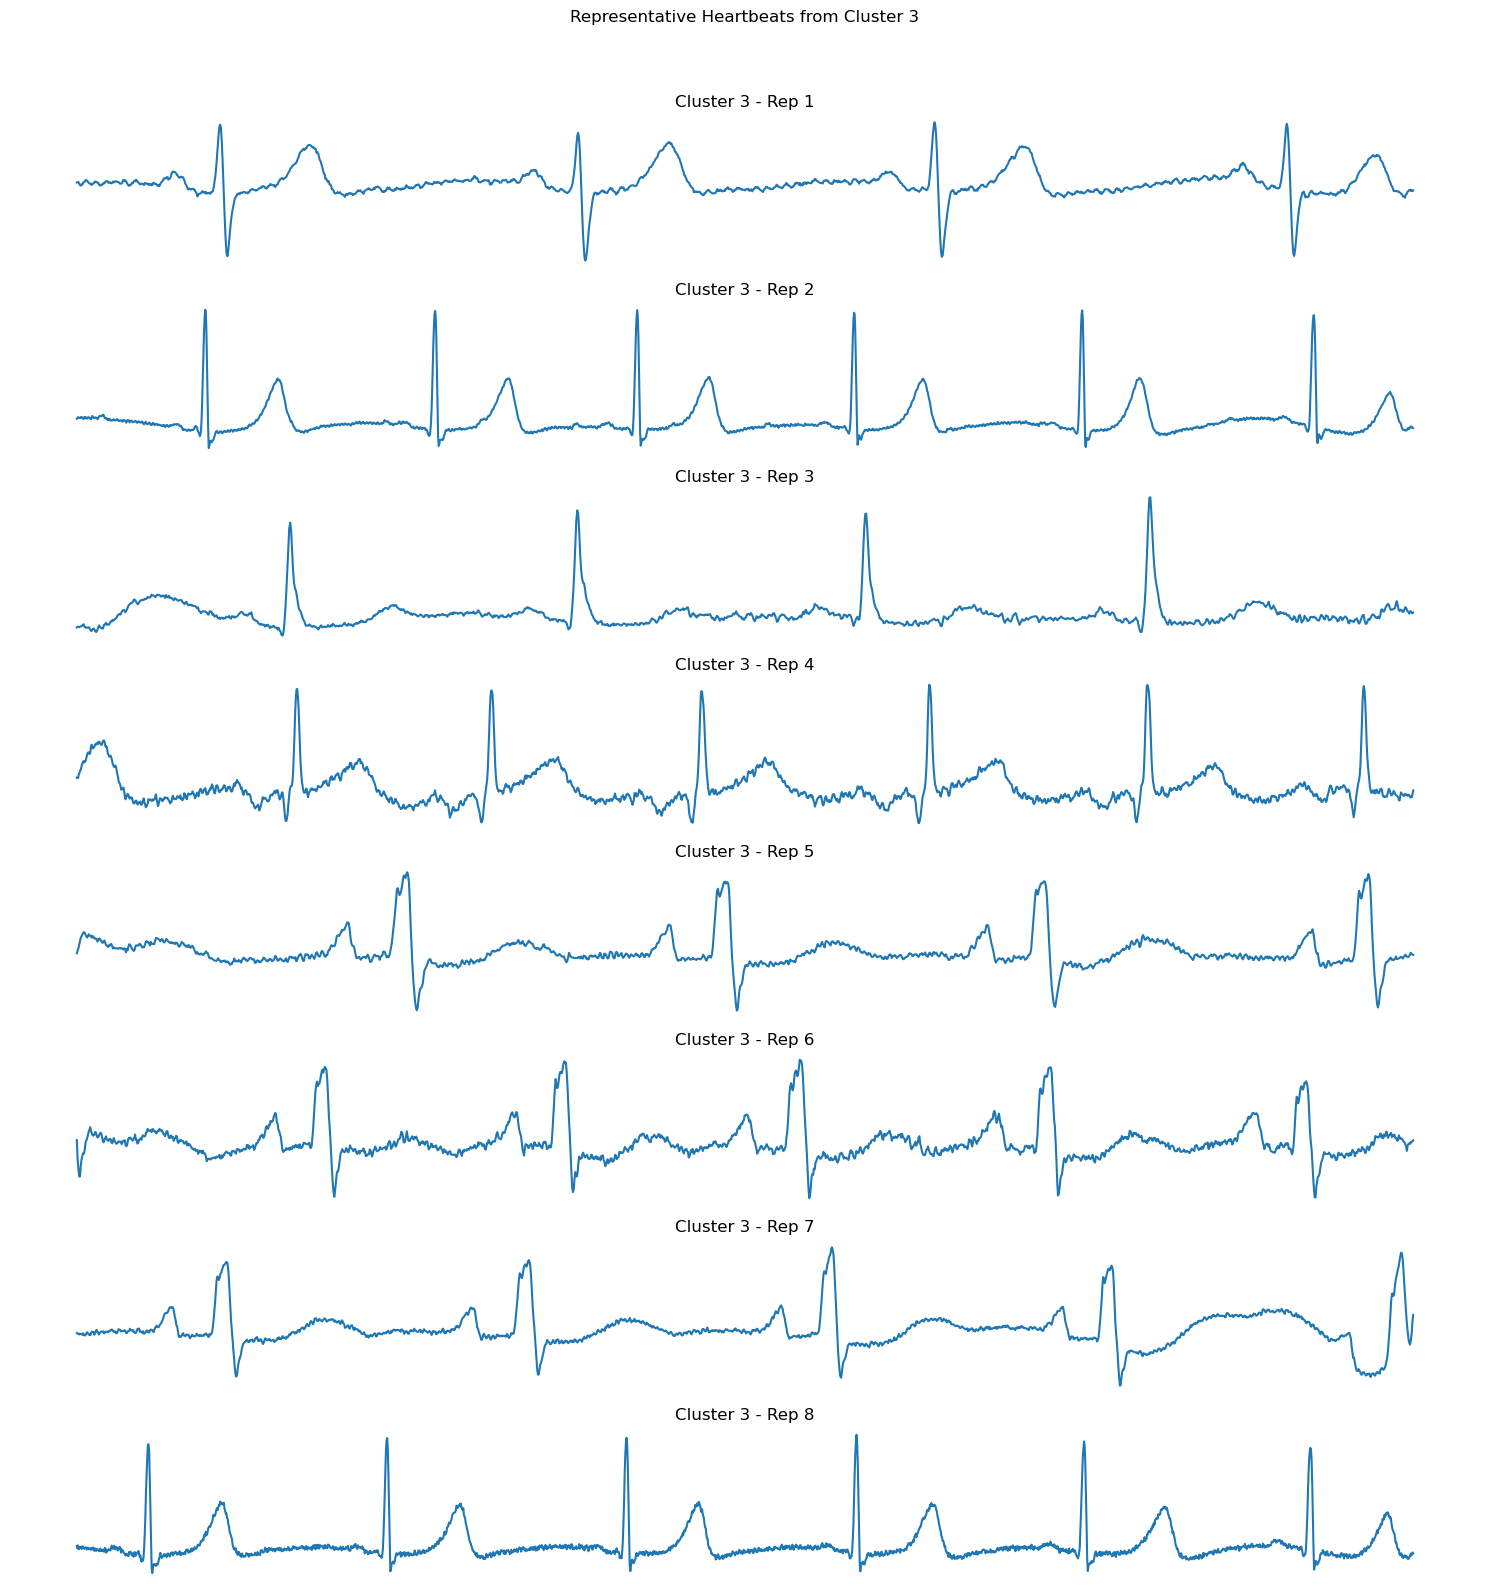

Principal Component 1 Loadings:
mean_rr: 0.7071
sdnn: 0.7071

Principal Component 2 Loadings:
mean_rr: -0.7071
sdnn: 0.7071



In [ ]:
import numpy as np
import scipy.stats as stats
from scipy.signal import welch, hilbert
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import mahalanobis
def extract_features_from_heartbeat(heartbeats, sampling_rate=360):
    features = []
    
    for heartbeat in heartbeats:

        peaks, properties = find_peaks(heartbeat, height=0.4, distance=40, prominence=2.2, width=(None,30))
        bpm = len(peaks)/len(heartbeat)
        distance_between_spikes = np.std(np.diff(peaks))
        ptp_std = np.std(heartbeat[peaks])
        # take std of peak to peak
        

        #windows_arr = get_heartbeat_windows([heartbeat], [peaks[0]])
        #length_window = np.std([len(window) for window in windows_arr[0]])
         # Morphological features

        #a = np.trapz(heartbeat)

        
        features.append([
           bpm, distance_between_spikes#, ptp_std
        ])
    
    features = np.array(features)
    
    # Normalize the features
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(features)
    
    return normalized_features

# Example usage
# Assuming `all_test_heartbeats` is defined elsewhere in your code

from scipy.signal import butter, filtfilt

def highpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

cutoff_frequency = 1  # Define your cutoff frequency in Hz
sampling_rate = 360  # Define your sampling rate in Hz

filtered_heartbeats = [highpass_filter(heartbeat, cutoff_frequency, sampling_rate) for heartbeat in unmixed_heartbeat]
print(len(filtered_heartbeats))

normalized_features = extract_features_from_heartbeat(filtered_heartbeats)

# Perform PCA on normalized features
pca = PCA(n_components=2)
pca_features = pca.fit_transform(normalized_features)

explained_variance = pca.explained_variance_ratio_
total_variance = np.sum(explained_variance)

gmm = GaussianMixture(n_components=2)
labels = gmm.fit_predict(normalized_features)

######################################## TOP 10 POINTS FROM EACH CLUSTER #############################################
means = gmm.means_
covariances = gmm.covariances_

furthest_points = {i: [] for i in range(3)}

for cluster_idx in range(2):
    # Select data points belonging to the current cluster
    cluster_points = normalized_features[labels == cluster_idx]
    
    # Compute the inverse of the covariance matrix for Mahalanobis distance
    inv_cov = np.linalg.inv(covariances[cluster_idx])
    
    # Calculate Mahalanobis distance for each point
    distances = [
        mahalanobis(point, means[cluster_idx], inv_cov) for point in cluster_points
    ]
    
    # Sort points by distance in descending order
    sorted_indices = np.argsort(distances)[::-1]
    
    # Get the top 10 furthest points (or fewer if less than 10)
    top_10_indices = sorted_indices[:10]
    furthest_points[cluster_idx] = top_10_indices



responsibilities = gmm.predict_proba(normalized_features)

# Predict the cluster for each point
cluster_assignments = gmm.predict(normalized_features)


for cluster_idx in range(3):
    # Select data points belonging to the current cluster
    cluster_points = normalized_features[cluster_assignments == cluster_idx]
    
    # Select responsibilities for the current cluster
    cluster_responsibilities = responsibilities[cluster_assignments == cluster_idx, cluster_idx]
    
    # Sort points by responsibility (ascending, since lower is less likely)
    sorted_indices = np.argsort(cluster_responsibilities)
    
    # Get the top 10 least likely points (lowest responsibility)
    top_10_indices = sorted_indices[:10]
    #unlikeliest_points[cluster_idx] = top_10_indices

#############################################################################
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
scatter = ax.scatter(pca_features[:, 0], pca_features[:, 1], c=labels, cmap='turbo', marker='o')
ax.set_title('2D PCA of Heartbeat Features with GMM Clustering')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
fig.colorbar(scatter, label='Cluster Label')
plt.show()

for i, variance in enumerate(explained_variance):
    print(f"Principal Component {i+1}: {variance:.2%} variance explained")

print(f"Total variance explained by selected components: {total_variance:.2%}")

# Plot ten representati
# Dictionary to store global indices of unlikeliest points
unlikeliest_points = {i: [] for i in range(3)}

for cluster_idx in range(3):
    # Get global indices of points belonging to the current cluster
    cluster_indices = np.where(labels == cluster_idx)[0]
    
    # Select normalized features for the current cluster
    cluster_points = normalized_features[cluster_indices]
    
    # Compute the log probability of each point under the Gaussian component
    log_probs = gmm.score_samples(cluster_points)
    
    # Sort points by log probability (ascending, since lower is less likely)
    sorted_indices = np.argsort(log_probs)
    
    # Get the top 10 least likely points (lowest log-probability)

    top_10_local_indices = sorted_indices[:min(len(sorted_indices),10)]
    #a = min(len(sorted_indices),10)  # Ensure unique indices
    
    # If fewer than 10 unique points are found, pad with additional points
    # while len(top_10_local_indices) < 10:
    #     a = min(len(top_10_local_indices),10])
    #     top_10_local_indices = np.concatenate(
    #         top_10_local_indices, sorted_indices[len(top_10_local_indices)]
    #     )
    
    # Convert local indices back to global indices
    top_10_global_indices = cluster_indices[top_10_local_indices]
    
    # Store global indices
    unlikeliest_points[cluster_idx] = top_10_global_indices

# Number of representatives to visualize per cluster
num_representatives = 10

for cluster in range(3):  # Iterate over each cluster
    plt.figure(figsize=(15, 20))
    
    for i, idx in enumerate(unlikeliest_points[cluster]):
        plt.subplot(num_representatives, 1, i + 1)
        plt.plot(filtered_heartbeats[idx])  # Use global index for plotting
        plt.title(f'Cluster {cluster + 1} - Rep {i + 1}')
        plt.axis('off')
    
    plt.suptitle(f'Representative Heartbeats from Cluster {cluster + 1}')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


# Number of representatives to visualize per cluster

# Get the loadings
loadings = pca.components_

# Print the loadings
feature_names = [
    "mean_rr", "sdnn", "rmssd", "pnn50"
]

for i, component in enumerate(loadings):
    print(f"Principal Component {i+1} Loadings:")
    for feature, loading in zip(feature_names, component):
        print(f"{feature}: {loading:.4f}")
    print()
